In [1]:
# Import the required libraries 

from bq_helper import BigQueryHelper
import bq_helper

from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

medicare = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="cms_medicare")
bq_assistant = BigQueryHelper("bigquery-public-data", "cms_medicare")

## 1. Which State has the highest (and lowest) number of Nursing Facilities

Skilled nursing facilities (SNFs) and nursing facilities (NFs) are provided by CMS under medicare. Different States of US have differnt number of nursing facilities.  Number of nursing facilities in a state might be an indicator of how good is the quality of care in different states. Lets obtain the number if of nursing facilities using 2014 dataset

![](http://www.arh.org/Uploads/Images/Page/services-skillednursing%5B1%5D.jpg)


In [2]:
# How many nurrsing facilitins in different States 
query1 = """SELECT
state, COUNT(state) as total_facilities
FROM
  `bigquery-public-data.cms_medicare.nursing_facilities_2014`
  GROUP BY 
  state
ORDER BY
  total_facilities DESC;"""
response1 = medicare.query_to_pandas_safe(query1)
response1.head(10)

,state,total_facilities
0,TX,1200
1,CA,1084
2,OH,936
3,IL,709
4,PA,703
5,FL,688
6,NY,618
7,IN,511
8,MO,497
9,MI,424


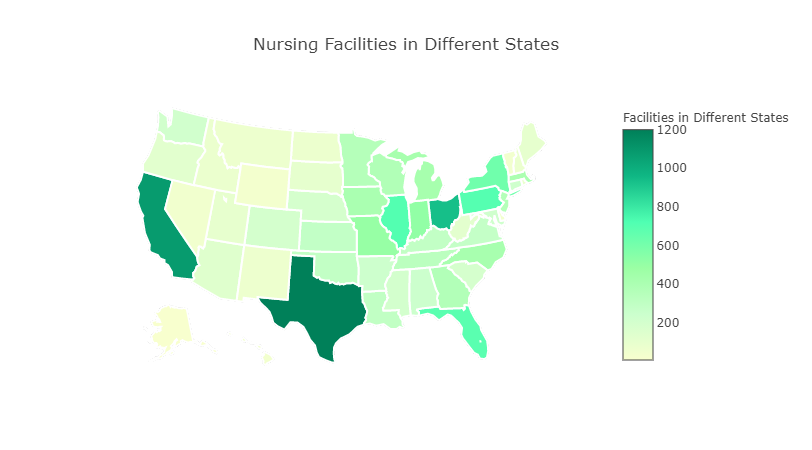

In [3]:
scl = [[0.0, 'rgb(248,255,206)'],[0.2, 'rgb(203,255,205)'],[0.4, 'rgb(155,255,164)'], [0.6, 'rgb(79,255,178)'],[0.8, 'rgb(15,183,132)'], [1, '#008059']]
query1 = """SELECT
state, COUNT(state) as total_facilities
FROM
  `bigquery-public-data.cms_medicare.nursing_facilities_2014`
  GROUP BY 
  state
ORDER BY
  total_facilities DESC;"""
response1 = medicare.query_to_pandas_safe(query1)
response1.head(10)
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = response1.state,
        z = response1.total_facilities,
        locationmode = 'USA-states',
        text = response1.state,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Facilities in Different States")
        )
       ]

layout = dict(
        title = 'Nursing Facilities in Different States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

**Inference**  
> Texas and California are the only states of US having more than 1000 Nursing Facilities   
> Purto Rico and Alaska are the states having exteremly low Nursing facilities with 5 and 7 respectively  
> About 40% of the total states have less than 200 nursing facilities 



## 2. Which State (and Nursing Facilities) have poor HCC risk adjustment scores 

The Center for Medicare & Medicaid Services (CMS) uses a Hierarchical Condition Category (HCC) risk adjustment model to calculate risk scores. The HCC model ranks diagnoses into categories that represent conditions with similar cost patterns. Higher categories represent higher predicted healthcare costs, resulting in higher risk scores. CMS uses HCCs to reimburse Medicare Advantage plans based on the health of their members. It pays accurately for the predicted cost expenditures of patients by adjusting those payments based on demographic information and patient health status. The risk assessment data used is based on the diagnosis information pulled from claims and medical records which are collected by physician offices, hospital inpatient visits and in outpatient settings.

CMS states that higher HCC scores means there is higher risk of chronic diseases while lower hcc indicates healthy population. It will be interesting to see what is the average hcc score for different states and facilities. 


### 2.1 Max and Min HCCs for different states


In [5]:
query2 = """SELECT
  state, AVG(average_hcc_score) as avg_hcc_score, Max(average_hcc_score) as max_hcc_score, Min(average_hcc_score) as min_hcc_score, COUNT(average_hcc_score) as total_facilities
FROM
  `bigquery-public-data.cms_medicare.nursing_facilities_2014`
  GROUP BY 
  state
ORDER BY
  avg_hcc_score DESC;
        """
response2 = medicare.query_to_pandas_safe(query2)
response2.head(10)

,state,avg_hcc_score,max_hcc_score,min_hcc_score,total_facilities
0,CA,2.612878,9.15,1.11,1084
1,LA,2.557959,4.91,1.39,294
2,NJ,2.555961,5.36,1.53,359
3,TX,2.545792,5.75,1.23,1200
4,FL,2.514390,5.70,1.11,688
5,NV,2.513182,4.73,1.49,44
6,MI,2.504481,7.12,1.20,424
7,OH,2.454872,7.07,0.85,936
8,GA,2.449700,4.31,1.30,367
9,AZ,2.415435,5.42,1.27,138


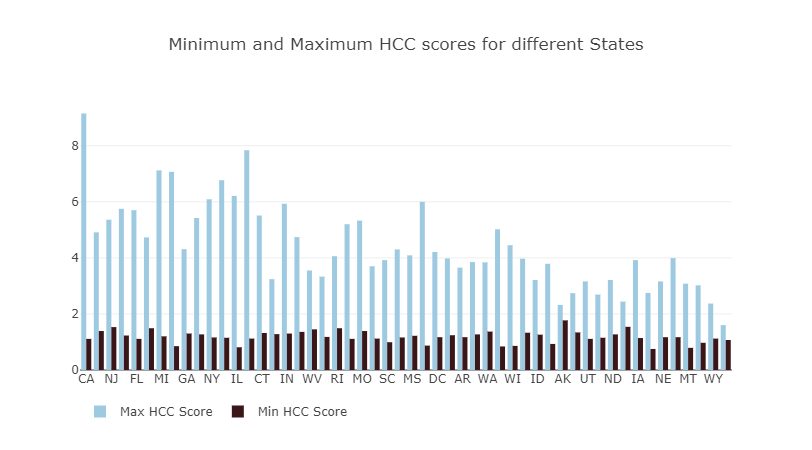

In [6]:
trace1 = go.Bar(
    x=response2.state,
    y=response2.max_hcc_score,
    name='Max HCC Score',
    marker=dict(color='rgb(158,202,225)'),
)
trace2 = go.Bar(
    x=response2.state,
    y=response2.min_hcc_score,
    name='Min HCC Score',
    marker=dict(color='rgb(58,22,25)'),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title='Minimum and Maximum HCC scores for different States',
    legend=dict(orientation="h")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

**Inference**  
> California's maximum HCC Score is exteremly high for one of the facility = 9.15  
> Other States having HCC score on the higher side: Pennsylvania (7.84), Minnesotta (7.12), OHIO (7.07)  
> Hawaii and Montana are the states having facilites with least possible HCC scores of 0.75 and 0.79 respectively 

### 2.2 Average HCC for different states

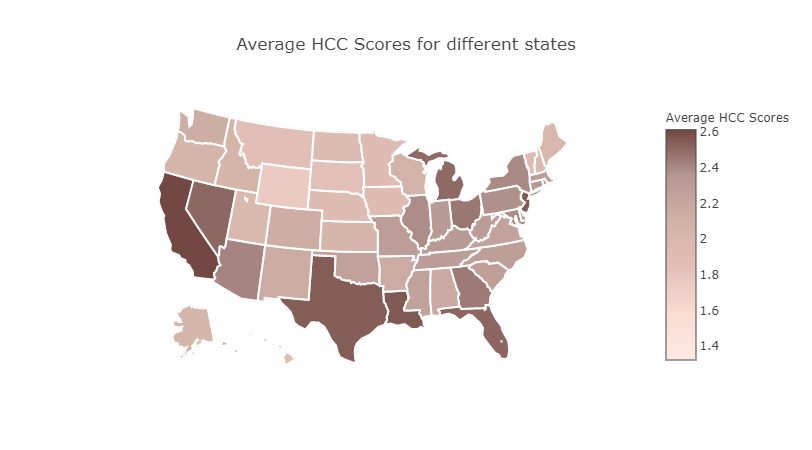

In [7]:
### Average HCC Scores for different states 

scl = [[0.0, 'rgb(255,233,225)'],[0.2, 'rgb(249,220,211)'],[0.4, 'rgb(227,192,183)'], [0.6, 'rgb(210,178,167)'],[0.8, 'rgb(182,151,146)'],[1.0, '#734842']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = response2.state,
        z = response2.avg_hcc_score,
        locationmode = 'USA-states',
        text = response2.state,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Average HCC Scores")
        )
       ]

layout = dict(
        title = 'Average HCC Scores for different states',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

**Inference**  
> States having highest Average HCC scores are California (2.6), Texas(2.5), Florida(2.5), Minnesotta (2.5), Louisiana(2.5), and New Jersy (2.5)  
> States having lowest Average HCC scores are Montana (1.8), South Dakota (1.8), Wyoming (1.7), Purto Rico (1.3)

### 2.3 Nursing Facilities with very HIGH HCC score

In [8]:
query3 = """SELECT facility_name, city, state, average_hcc_score
FROM `bigquery-public-data.cms_medicare.nursing_facilities_2014`
ORDER BY average_hcc_score DESC;
        """
response3 = medicare.query_to_pandas_safe(query3)
response3.head(5)

,facility_name,city,state,average_hcc_score
0,DOCTORS HOSP OF WEST COVINA,WEST COVINA,CA,9.15
1,FOX SUBACUTE AT MECHANICSBURG,MECHANICSBURG,PA,7.84
2,OMNI CONTINUING CARE,DETROIT,MI,7.12
3,ORCHARDS OF RIDGEWOOD LIVING & REHAB CTR THE,AKRON,OH,7.07
4,MANORCARE HEALTH SYSTEM - ADELPHI,ADELPHI,MD,6.77


### 2.4 Nursing Facilities with very LOW HCC score

In [9]:
response3.tail(5)

,facility_name,city,state,average_hcc_score
15021,MERCER COUNTY JOINT TOWNSHIP COMMUNITY HOSPITAL,COLDWATER,OH,0.85
15022,ST ANTHONY SUMMIT MEDICAL CENTER,FRISCO,CO,0.84
15023,ALDEN ESTATES OF SKOKIE,SKOKIE,IL,0.81
15024,POWDER RIVER MANOR,BROADUS,MT,0.79
15025,KFH - MALAMA 'OHANA NURSING AND REHAB CENTER,HONOLULU,HI,0.75


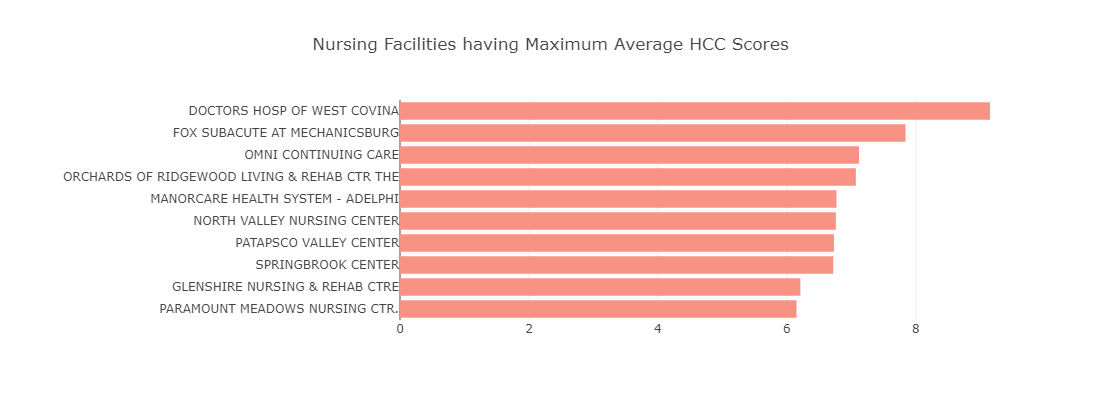

In [10]:
tempdf = response3.head(10)
y = list(reversed(list(tempdf.facility_name)))
x = list(reversed(list(tempdf.average_hcc_score)))
trace1 = go.Bar(x=x, y=y, orientation="h", marker=dict(color='#f79284'),)
layout = dict(height=400, width=700, margin=dict(l=400), title='Nursing Facilities having Maximum Average HCC Scores')
data = [trace1]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

**Inference**  
> Facilities having highest Average HCC Score of 9.15 is Doctors Hosp of West Covina, located in California.  
> KFH - Malama Ohana Nursing and Rehab Center' in HONOLULU, Hawaii has the lowest Average HCC Score

## 3. Is there any state where the number of Male Beneficiaries is greater than Female Beneficiaries ?

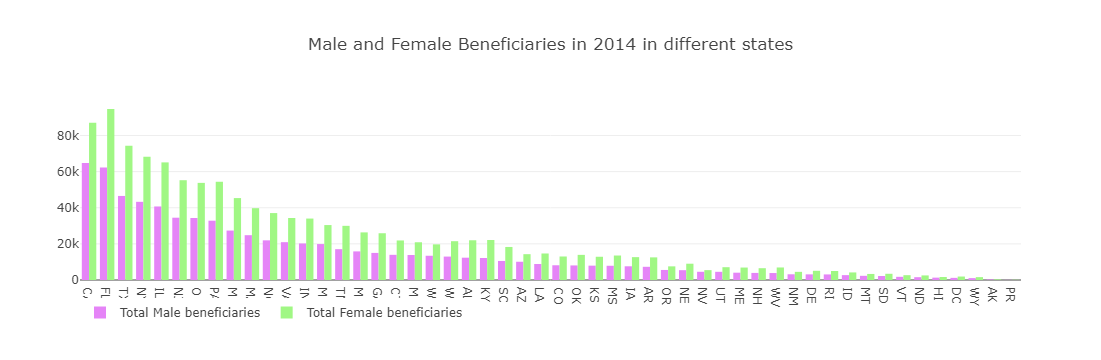

In [11]:
query1 = """SELECT
  state, Sum(male_beneficiaries) as male_ben, Sum(female_beneficiaries) as female_ben
FROM
  `bigquery-public-data.cms_medicare.nursing_facilities_2014`
  GROUP BY 
      state
  ORDER BY
      male_ben DESC;
        """
response1 = medicare.query_to_pandas_safe(query1)


trace1 = go.Bar(
    x=response1.state,
    y=response1.male_ben,
    marker=dict(color='#e584f7'),
    name='Total Male beneficiaries'
)
trace2 = go.Bar(
    x=response1.state,
    y=response1.female_ben,
    marker=dict(color='#a0f784'),
    name='Total Female beneficiaries'
)

data = [trace1, trace2]
layout = go.Layout(barmode='group', legend=dict(orientation='h'), title='Male and Female Beneficiaries in 2014 in different states')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

**Inference**  
> All of the states have more female beneficiaries than male beneficiaries, which indicates that there might exist a fixed quota for number of beneficiaries.   
> Highest number of feamle beneficiaries are from Florida State while highest number of male beneficiaries are from California State

### 3.2 Difference in Male and Female Beneficiaries

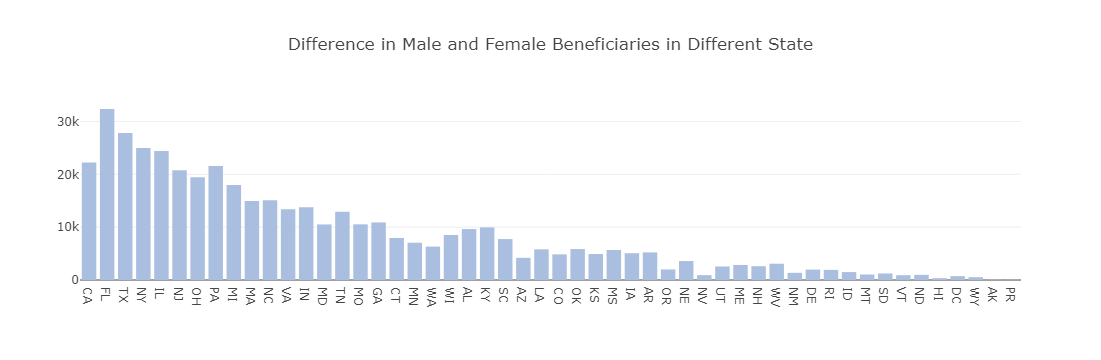

In [12]:
response1['difference'] = response1['female_ben'] - response1['male_ben']

trace1 = go.Bar(
    x=response1.state,
    y=response1.difference,
    marker=dict(color='#aabfe0'),
    name='Total Male beneficiaries'
)
data = [trace1]
layout = go.Layout(barmode='group', legend=dict(orientation='h'), title='Difference in Male and Female Beneficiaries in Different State')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

**Inference**  
> Florida has the highest gap in number of male vs female beneficiaries with about 30,000 more female beneficiaries  
> Alaska, Purto Rico, Hawaii, Wyoming has the lowest

### 3.3 Difference in Average Inpatient payment and Average Outpatient payments

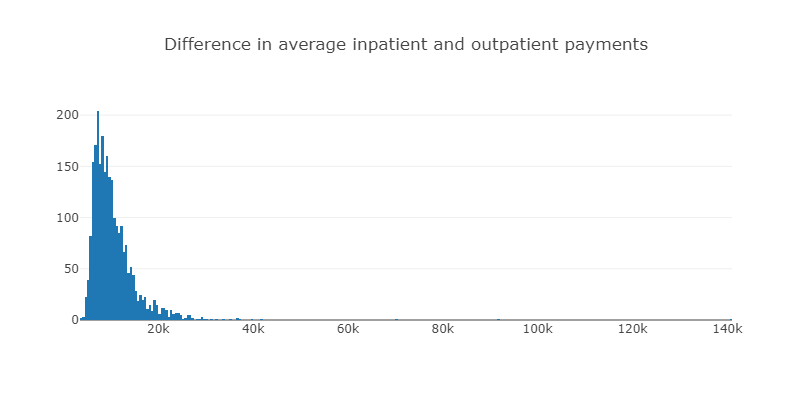

In [13]:
query3_a = """SELECT provider_id, avg(average_total_payments) as average_outpatient_payments
FROM `bigquery-public-data.cms_medicare.outpatient_charges_2014` group by provider_id;"""
outp = medicare.query_to_pandas_safe(query3_a)

query3_b = """SELECT provider_id, avg(average_total_payments) as average_inpatient_payments
FROM `bigquery-public-data.cms_medicare.inpatient_charges_2014` group by provider_id;"""
inp = medicare.query_to_pandas_safe(query3_b)

merged = outp.merge(inp, on="provider_id", how = 'inner')
merged["difference"] = merged["average_inpatient_payments"] - merged['average_outpatient_payments']

tracex = go.Histogram(x = merged["difference"]) 
fig = go.Figure(data = [tracex])
fig['layout'].update(height=400, showlegend=False, title="Difference in average inpatient and outpatient payments");
iplot(fig, filename='simple-subplot');

## 4. Finding States / Facilities with poor average length of stay days 

### 4.1 States and their average total number stays (of different facilities) and average length of stays (in different facilities)

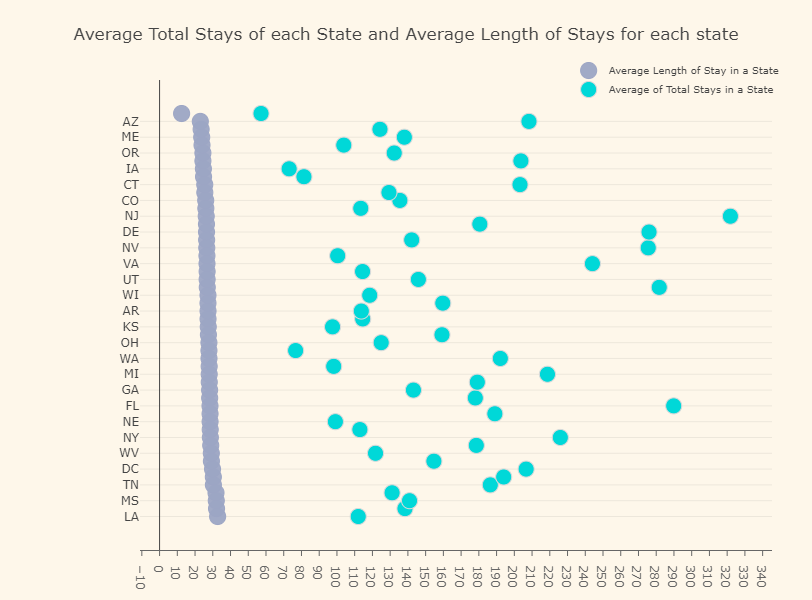

In [14]:
query2 = """SELECT
  state, AVG(average_length_of_stays_days) as average_length_of_stays_days, AVG(total_stays) as total_stays
FROM
  `bigquery-public-data.cms_medicare.nursing_facilities_2014`
  GROUP BY 
  state
ORDER BY
  average_length_of_stays_days DESC;
        """
response2 = medicare.query_to_pandas_safe(query2)
response2.head(10)


trace0 = go.Scatter(
    x=response2.average_length_of_stays_days,
    y=response2.state,
    mode='markers',
    name='Average Length of Stay in a State',
    marker=dict(
        color='rgba(156, 165, 196, 0.95)',
        line=dict(
            color='rgba(156, 165, 196, 1.0)',
            width=1,
        ),
        symbol='circle',
        size=16,
    )
)
trace1 = go.Scatter(
    x=response2.total_stays,
    y=response2.state,
    mode='markers',
    name='Average of Total Stays in a State ',
    marker=dict(
        color='#00d8d8',
        line=dict(
            color='rgba(217, 217, 217, 1.0)',
            width=1,
        ),
        symbol='circle',
        size=16,
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title="Average Total Stays of each State and Average Length of Stays for each state ",
    xaxis=dict(
        showgrid=False,
        showline=True,
        linecolor='rgb(102, 102, 102)',
        titlefont=dict(
            color='rgb(204, 204, 204)'
        ),
        tickfont=dict(
            color='rgb(102, 102, 102)',
        ),
#         autotick=False,
        dtick=10,
        ticks='outside',
        tickcolor='rgb(102, 102, 102)',
    ),
    margin=dict(
        l=140,
        r=40,
        b=50,
        t=80
    ),
    legend=dict(
        font=dict(
            size=10,
        ),
        yanchor='middle',
        xanchor='right',
    ),
#     width=800,
    height=600,
    paper_bgcolor='rgb(254, 247, 234)',
    plot_bgcolor='rgb(254, 247, 234)',
    hovermode='closest',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lowest-oecd-votes-cast')

**Inference**  
> - Average Length of Stay among the patients in all the states is very close to 30 days. (They also want to avoid 30-day readmission penalty)  
> - Arizona has the significantly lower average lenght of stay equal to 22 which is quite less as compared to other states   
> - Louisiana, Texas, Illinois, Mississippi are the states having greater than 30 day average length of stay, which indicates that patients are admitted there for longer number of days than average  
> - Purto Rico, a territory of US has the lowest average length of stay among all the states and terriroties equal to 12.
  
  > - New Jersy's nursing facilities has on-an-average very large number of total stays (equal to 321)  
  > - Iowa has the minium among the states equal to 73 total stays among its nursing facilities

### 4.2 Facilities having highest average length of stay days

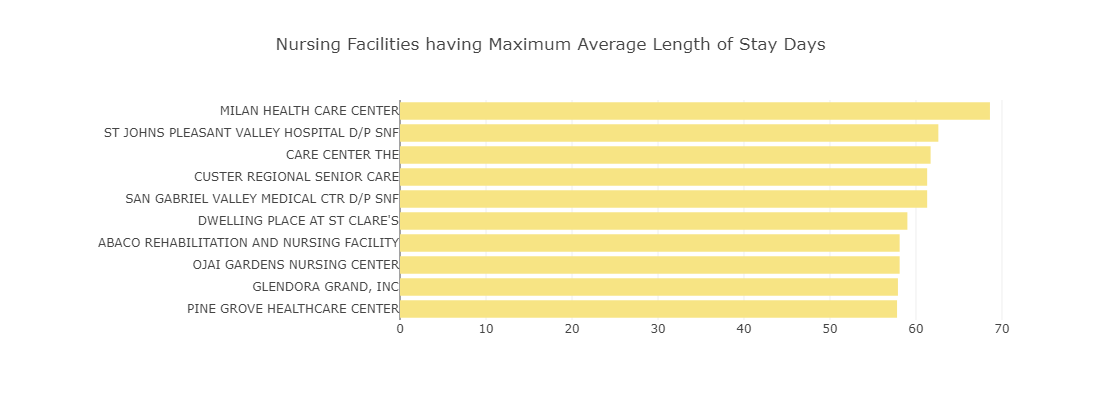

In [15]:
# which facilities have highest stays count 

query1 = """SELECT
  facility_name, city, state, average_length_of_stays_days
FROM
  `bigquery-public-data.cms_medicare.nursing_facilities_2014`
ORDER BY
  average_length_of_stays_days DESC;
        """
response1 = medicare.query_to_pandas_safe(query1)

tempdf = response1.head(10)
y = list(reversed(list(tempdf.facility_name)))
x = list(reversed(list(tempdf.average_length_of_stays_days)))
trace1 = go.Bar(x=x, y=y, orientation="h", marker=dict(color='#f7e484'))
layout = dict(height=400, width=700, title='Nursing Facilities having Maximum Average Length of Stay Days', margin=dict(l=400))
data = [trace1]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

## 5. Lets Explore the Total Claims, Day Supply and Drug Costs 

### 5.1 Which State has highest claims, Day Supply, and Drug Costs

In [16]:
query1 = """SELECT
  nppes_provider_state AS state,
  ROUND(SUM(total_claim_count) / 1e6) AS total_claim_count_millions,
  ROUND(SUM(total_day_supply) / 1e6) AS total_day_supply_millions,
  ROUND(SUM(total_drug_cost) / 1e6) AS total_drug_cost_millions
FROM
  `bigquery-public-data.cms_medicare.part_d_prescriber_2014`
GROUP BY
  state
ORDER BY
  total_claim_count_millions DESC;
        """
response1 = medicare.query_to_pandas_safe(query1)
response1.head(10)

,state,total_claim_count_millions,total_day_supply_millions,total_drug_cost_millions
0,CA,116.0,4935.0,9633.0
1,FL,91.0,3769.0,6970.0
2,NY,80.0,3150.0,7522.0
3,TX,76.0,3105.0,6462.0
4,PA,63.0,2402.0,4842.0
5,OH,53.0,2181.0,4051.0
6,NC,46.0,1706.0,3358.0
7,IL,43.0,1724.0,3121.0
8,MI,39.0,1797.0,3193.0
9,GA,39.0,1403.0,2787.0


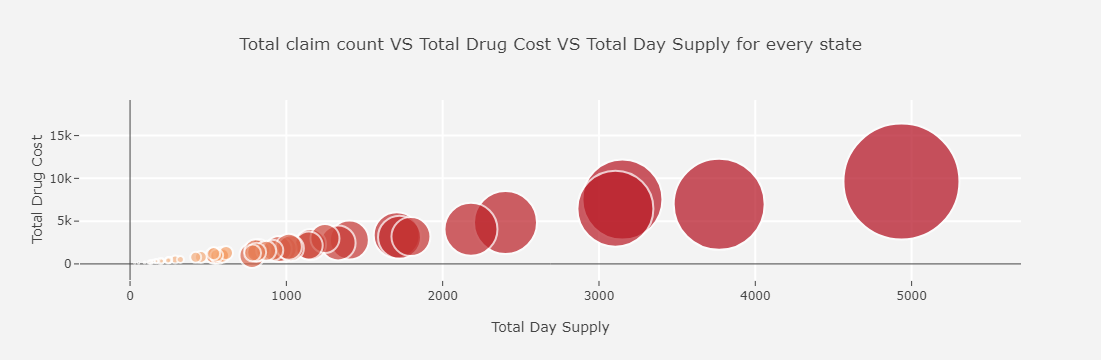

In [17]:
trace1 = go.Scatter(
    x=response1.total_day_supply_millions,
    y=response1.total_drug_cost_millions,
    mode='markers',
    text=response1.state,
    marker=dict(
        color=list(reversed([i*11 for i in range(200,251)])),
        size=response1.total_claim_count_millions,
        line=dict(
            width=2
        ),
    )
)
data = [trace1]

layout = go.Layout(
    title='Total claim count VS Total Drug Cost VS Total Day Supply for every state',
    xaxis=dict(
        title='Total Day Supply',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Total Drug Cost',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-colorscale')

**Inference**  
> California is the state having highest total day supply, highest total drug cost and highest claim count.  
> Other states having more claim counts include Florida, Texas, and New York 

### 5.2 Which Drugs have been most prescribed in US

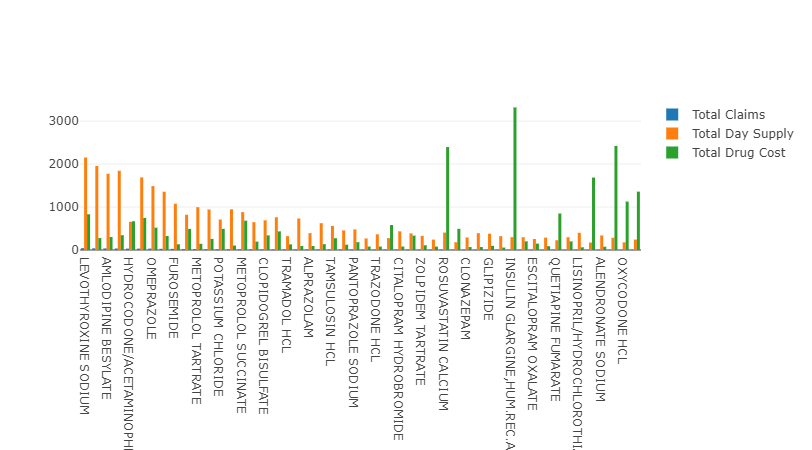

In [18]:
# state wise count of claims 

## Which providers have highest claims 

query1 = """SELECT
  generic_name AS drug_name,
  ROUND(SUM(total_claim_count) / 1e6) AS total_claim_count_millions,
  ROUND(SUM(total_day_supply) / 1e6) AS total_day_supply_millions,
  ROUND(SUM(total_drug_cost) / 1e6) AS total_drug_cost_millions
FROM
  `bigquery-public-data.cms_medicare.part_d_prescriber_2014`
GROUP BY
  drug_name
ORDER BY
  total_claim_count_millions DESC;
        """
response1 = medicare.query_to_pandas_safe(query1)
tempdf = response1.head(50)

trace1 = go.Bar(
    x=tempdf.drug_name,
    y=tempdf.total_claim_count_millions,
    name='Total Claims'
)
trace2 = go.Bar(
    x=tempdf.drug_name,
    y=tempdf.total_day_supply_millions,
    name='Total Day Supply'
)
trace3 = go.Bar(
    x=tempdf.drug_name,
    y=tempdf.total_drug_cost_millions,
    name='Total Drug Cost'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group'
    , margin=dict(b=200)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

**Inference**  

![](https://img.medscapestatic.com/pi/features/drugdirectory/octupdate/APP06470.jpg)

> - Levothyroxine Sodium and LISINOPRIL are the drugs which are associated with the highest number of claims  as well as highest number of supply  
> - Insulin Glargine, Hum.Rec.An is the drug which is associated with the highest Total Drug Cost  
> - Drugs having more Total Supply than Drug Costs are AMLODIPINE BESYLATE and SIMVASTATIN  
> - Drugs having more Total Cost than Supply are Rosuvastatin Calcium, and Esomeprazole magnesium

### 5.3 What about Nursing Specialities associated with highest claims

In [19]:
query1 = """SELECT
  specialty_description AS specialty_description,
  ROUND(SUM(total_claim_count) / 1e6) AS total_claim_count_millions,
  ROUND(SUM(total_day_supply) / 1e6) AS total_day_supply_millions,
  ROUND(SUM(total_drug_cost) / 1e6) AS total_drug_cost_millions
FROM
  `bigquery-public-data.cms_medicare.part_d_prescriber_2014`
GROUP BY
  specialty_description
ORDER BY
  total_claim_count_millions DESC;
        """
response1 = medicare.query_to_pandas_safe(query1)
tempdf = response1.head(40)
tempdf['specialty_description1'] = tempdf['specialty_description'].apply(lambda x: x.replace(" ","_"))

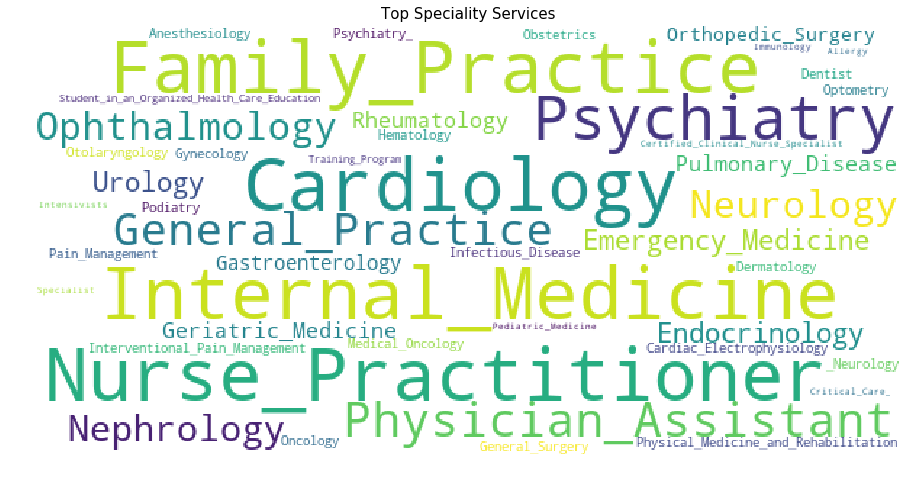

In [20]:
txt = " ".join(tempdf.specialty_description1)
wordcloud = WordCloud(background_color='white', max_font_size=50, width=600, height=300).generate(txt)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.title("Top Speciality Services", fontsize=15)
plt.axis("off")
plt.show() 

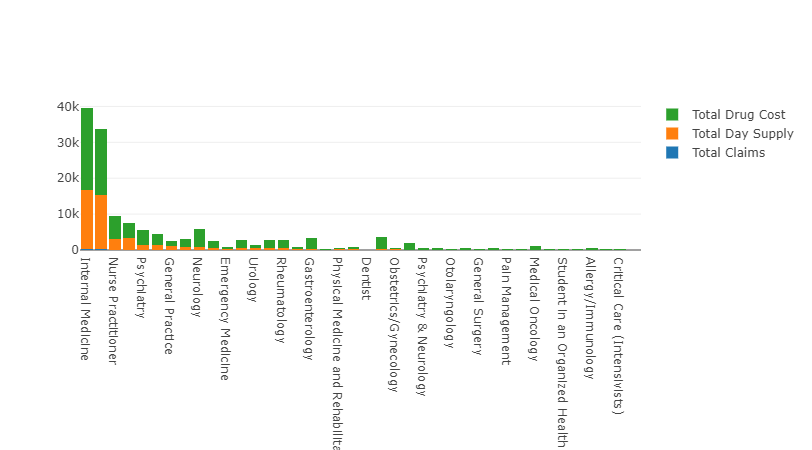

In [21]:
trace1 = go.Bar(
    x=tempdf.specialty_description,
    y=tempdf.total_claim_count_millions,
    name='Total Claims'
)
trace2 = go.Bar(
    x=tempdf.specialty_description,
    y=tempdf.total_day_supply_millions,
    name='Total Day Supply'
)
trace3 = go.Bar(
    x=tempdf.specialty_description,
    y=tempdf.total_drug_cost_millions,
    name='Total Drug Cost'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='stack'
    , margin=dict(b=200)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

**Inference**
> Internal Medicine and Family Pracitve are associated with highest claims   
> These specialities also have highest total drug cost. Other Specialities with similar stats include Nurse Practitioner, Cardiology and General Practice

### 5.4 Which Drugs are most prescribed in each state 

In [22]:
query1 = """select A.state, B.drug_name, A.MaxClaimCount from (select state, MAX(total_claim_count_millions) as MaxClaimCount from (
SELECT
  nppes_provider_state AS state, generic_name AS drug_name, SUM(total_claim_count) AS total_claim_count_millions
FROM
  `bigquery-public-data.cms_medicare.part_d_prescriber_2014`
GROUP BY state, drug_name
ORDER BY
  total_claim_count_millions DESC) group by state) A INNER JOIN (SELECT
  nppes_provider_state AS state,
  generic_name AS drug_name,
  SUM(total_claim_count) AS total_claim_count_millions
FROM
  `bigquery-public-data.cms_medicare.part_d_prescriber_2014`
GROUP BY
  state, drug_name
ORDER BY
  total_claim_count_millions DESC) B ON A.MaxClaimCount = B.total_claim_count_millions;
"""
response1 = medicare.query_to_pandas_safe(query1)

visited = {}
rows = []
for index, row in response1.iterrows():
    stat = row['state']
    if stat not in visited:
        visited[stat] = 1
        rows.append(row)
newDF = pd.DataFrame(rows).reset_index()
newDF[['state', 'drug_name', 'MaxClaimCount']].head(21)

,state,drug_name,MaxClaimCount
0,MI,HYDROCODONE/ACETAMINOPHEN,1792522
1,FL,LEVOTHYROXINE SODIUM,2982449
2,OH,LEVOTHYROXINE SODIUM,1813810
3,SC,HYDROCODONE/ACETAMINOPHEN,705275
4,TN,HYDROCODONE/ACETAMINOPHEN,1377467
5,UT,LEVOTHYROXINE SODIUM,253237
6,NV,HYDROCODONE/ACETAMINOPHEN,294635
7,AZ,LEVOTHYROXINE SODIUM,866240
8,TX,HYDROCODONE/ACETAMINOPHEN,2833795
9,NY,AMLODIPINE BESYLATE,2609790


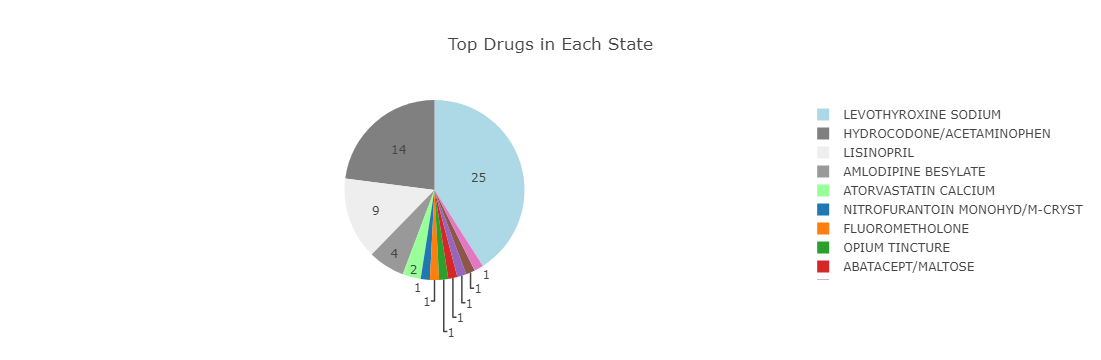

In [23]:
a = newDF['drug_name'].value_counts()
labels = a.index
values = a.values
colors = ['lightblue','gray','#eee','#999', '#9f9f']
trace = go.Pie(labels=labels, values=values, hoverinfo='label+percent', 
               textinfo='value', name='Top Drugs Used',
               marker=dict(colors=colors))
layout = dict(title = 'Top Drugs in Each State',
              xaxis= dict(title= 'Drug Name', ticklen= 5,zeroline= False),
              width=800
             )
fig = dict(data = [trace], layout = layout)
iplot(fig)

### 5.5 Most Common Provider Types in US 

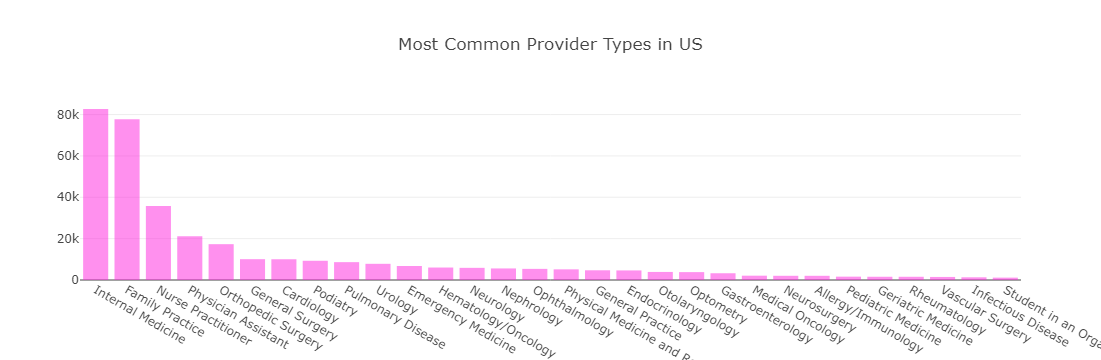

In [24]:
query1 = """SELECT provider_type, COUNT(provider_type) as count FROM
  `bigquery-public-data.cms_medicare.referring_durable_medical_equip_2014`
  GROUP BY provider_type ORDER BY count DESC;"""
response1 = medicare.query_to_pandas_safe(query1)

trace1 = go.Bar(x=list(response1.head(30)['provider_type']),
    y=list(response1.head(30)['count']),
    name='Popular Provider Types ',
    marker=dict(color='#ff23de'), opacity=0.5,
)

data = [trace1]
layout = go.Layout(
    barmode='group',
    title='Most Common Provider Types in US',
    legend=dict(orientation="h")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [25]:
# query1 = """SELECT provider_type, COUNT(provider_type) as count FROM
#   `bigquery-public-data.cms_medicare.referring_durable_medical_equip_2014`
#   GROUP BY provider_type ORDER BY count DESC;"""
# response1 = medicare.query_to_pandas_safe(query1)

# trace1 = go.Bar(x=list(response1.head(30)['provider_type']),
#     y=list(response1.head(30)['count']),
#     name='Popular Provider Types ',
#     marker=dict(color='#ff23de'), opacity=0.5,
# )

# data = [trace1]
# layout = go.Layout(
#     barmode='group',
#     title='Most Common Provider Types in US',
#     legend=dict(orientation="h")
# )

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)

## 6. Clustering Nursing Facilities having similar behaviours 

In this section, we will try to cluster the nursing facilities based on the 29 key features about them. I have choosen following features based on the amount of missing values and healthcare domain importance. 

 **features_used_for_clustering** = [  'total_stays', 'distinct_beneficiaries_per_provider',
   'average_length_of_stays_days', 'total_snf_charge_amount',
   'total_snf_medicare_allowed_amount',
   'total_snf_medicare_payment_amount',
   'total_snf_medicare_standard_payment_amount', 'average_age',
   'male_beneficiaries', 'female_beneficiaries', 'nondual_beneficiaries',
   'dual_beneficiaries', 'white_beneficiaries', 'black_beneficiaries'
   , 'average_hcc_score',
   'percent_of_beneficiaries_with_atrial_fibrillation',
   'percent_of_beneficiaries_with_asthma',
   'percent_of_beneficiaries_with_cancer',
   'percent_of_beneficiaries_with_chf',
   'percent_of_beneficiaries_with_chronic_kidney_disease',
   'percent_of_beneficiaries_with_copd',
   'percent_of_beneficiaries_with_depression',
   'percent_of_beneficiaries_with_diabetes',
   'percent_of_beneficiaries_with_hyperlipidemia',
   'percent_of_beneficiaries_with_ihd',
   'percent_of_beneficiaries_with_osteoporosis',
   'percent_of_beneficiaries_with_ra_oa',
   'percent_of_beneficiaries_with_schizophrenia',
   'percent_of_beneficiaries_with_stroke']
   
### 6.1 K-Means Clustering 

By hit-and-trial and running elbow method iteratively, I have choosen the number of clusters to be equal to 3. ie. every nursing facility will be classified to one of the three clusters. This will help to identify the Nursing Facilities having similar behaviours / characteristics. Before Running Clustering I have applied data Preprocessing which includes Removing textual columns and dropping the missing Values

Reference - https://en.wikipedia.org/wiki/K-means_clustering

In [26]:
query1 = """SELECT provider_id, facility_name, city, state, total_stays, distinct_beneficiaries_per_provider,
       average_length_of_stays_days, total_snf_charge_amount,
       total_snf_medicare_allowed_amount,
       total_snf_medicare_payment_amount,
       total_snf_medicare_standard_payment_amount, average_age,
       male_beneficiaries, female_beneficiaries, nondual_beneficiaries,
       dual_beneficiaries, white_beneficiaries, black_beneficiaries, average_hcc_score,
       percent_of_beneficiaries_with_atrial_fibrillation,
       percent_of_beneficiaries_with_asthma,
       percent_of_beneficiaries_with_cancer,
       percent_of_beneficiaries_with_chf,
       percent_of_beneficiaries_with_chronic_kidney_disease,
       percent_of_beneficiaries_with_copd,
       percent_of_beneficiaries_with_depression,
       percent_of_beneficiaries_with_diabetes,
       percent_of_beneficiaries_with_hyperlipidemia,
       percent_of_beneficiaries_with_ihd,
       percent_of_beneficiaries_with_osteoporosis,
       percent_of_beneficiaries_with_ra_oa,
       percent_of_beneficiaries_with_schizophrenia,
       percent_of_beneficiaries_with_stroke FROM
  `bigquery-public-data.cms_medicare.nursing_facilities_2014`;"""
response1 = medicare.query_to_pandas_safe(query1)

# preprocessing the data before applying clustering 
X = response1
X.index = X.provider_id
X = X.drop(['provider_id', 'facility_name', 'city', 'state'], axis=1)
X = X.dropna()

# apply k-means clustering
from sklearn.cluster import KMeans 
import numpy as np 
kmeans = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=0) 
X['cluster'] = kmeans.fit_predict(X)

### 6.2 Exploring the Clusters of Nursing Facilities 

Let us now explore the clusters / groups of nursing facilities. 

In [27]:
print ("Group A Cluster Elements: ")
cluster_elements = list(X[X['cluster'] == 0].index[:5])
temp = response1.loc[response1['provider_id'].isin(cluster_elements)]
j = 1
for i, row in temp[['facility_name', 'city', 'state']].iterrows():
    print (j, "\t "+", ".join(list(row)).title())
    j+= 1
print ()

print ("Group B Cluster Elements: ")
cluster_elements = list(X[X['cluster'] == 1].index[:5])
temp = response1.loc[response1['provider_id'].isin(cluster_elements)]
j = 1
for i, row in temp[['facility_name', 'city', 'state']].iterrows():
    print (j, "\t "+", ".join(list(row)).title())
    j+= 1
print ()    

print ("Group C Cluster Elements: ")
cluster_elements = list(X[X['cluster'] == 2].index[:5])
temp = response1.loc[response1['provider_id'].isin(cluster_elements)]
j = 1
for i, row in temp[['facility_name', 'city', 'state']].iterrows():
    print (j, "\t "+", ".join(list(row)).title())
    j+= 1
print ()

print ("Group D Cluster Elements: ")
cluster_elements = list(X[X['cluster'] == 3].index[:5])
temp = response1.loc[response1['provider_id'].isin(cluster_elements)]
j = 1
for i, row in temp[['facility_name', 'city', 'state']].iterrows():
    print (j, "\t "+", ".join(list(row)).title())
    j+= 1

Group A Cluster Elements: 
1 	 Sandstone Heights, Little River, Ks
2 	 Windsormeade Of Williamsburg, Williamsburg, Va
3 	 Mechanicsville Nursing & Rehab Center, Mechanicsville, Ia
4 	 Gregory Wing Of St Andrews Village, Boothbay Harbor, Me
5 	 Village Care Center Inc, Maryville, Mo

Group B Cluster Elements: 
1 	 Manor Care Health Services, Reno, Nv
2 	 Kindred Transitional Care And Rehab-Tunnell Center, San Francisco, Ca
3 	 Carlton At The Lake, The, Chicago, Il
4 	 Regeis Care Center, Bronx, Ny
5 	 New Hope Post Acute Care, Tracy, Ca

Group C Cluster Elements: 
1 	 Life Care Center Of Winter Haven, Winter Haven, Fl
2 	 Villa At Evergreen Park,The, Evergreen Park, Il
3 	 Montowese Health & Rehab Ctr,, North Haven, Ct
4 	 Manorcare Health Services-Walnut Creek, Walnut Creek, Ca
5 	 Care One At Ridgewood Avenue, Paramus, Nj

Group D Cluster Elements: 
1 	 Marshfield Care Center, Marshfield, Wi
2 	 Thibodaux Healthcare Center, Thibodaux, La
3 	 Mercy Retirement & Care Center, Oakland, Ca

### 6.3 Mean Value of Key Features of Groups 

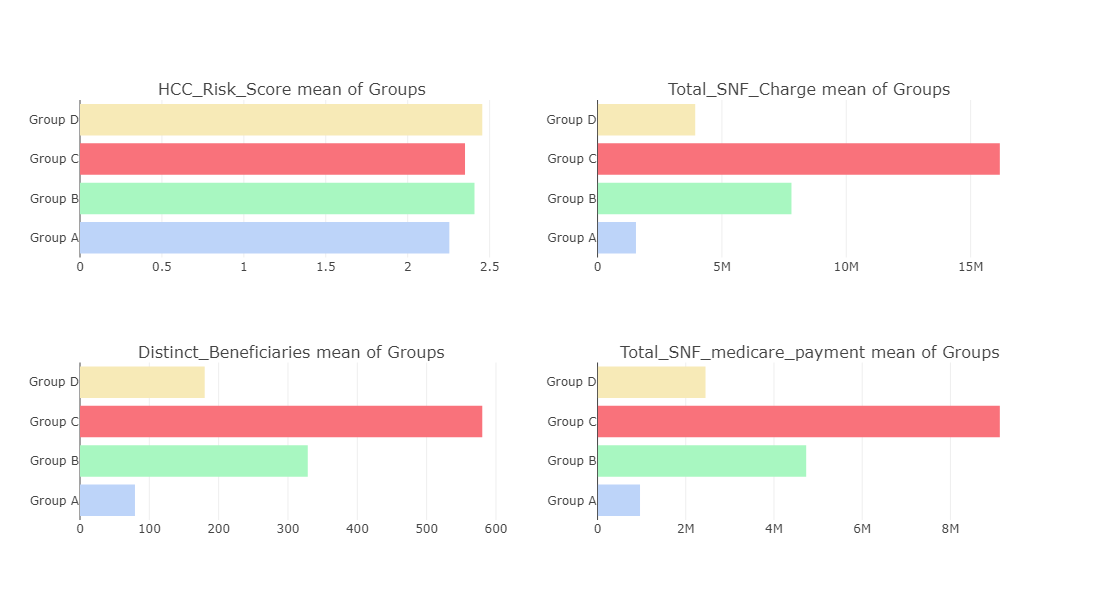

In [28]:
def plot_cluster_variables(col):
    mean_score1 =  (np.mean(X[X['cluster'] == 0][col]))
    mean_score2 = (np.mean(X[X['cluster'] == 1][col]))
    mean_score3 = (np.mean(X[X['cluster'] == 2][col]))
    mean_score4 = (np.mean(X[X['cluster'] == 3][col]))

    trace1 = go.Bar(
        y = ['Group A', 'Group B', 'Group C', 'Group D'],
        x = [mean_score1, mean_score2, mean_score3, mean_score4],
        orientation = 'h',
        marker=dict(color=['#bdd4f9', '#a8f7c1', '#f9727b', '#f7eab7'])
    )
    return trace1

f1 = plot_cluster_variables('average_hcc_score')
f2 = plot_cluster_variables('total_snf_charge_amount')
f3 = plot_cluster_variables('distinct_beneficiaries_per_provider')
f4 = plot_cluster_variables('total_snf_medicare_payment_amount')

fig = tools.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=('HCC_Risk_Score mean of Groups','Total_SNF_Charge mean of Groups', 'Distinct_Beneficiaries mean of Groups', 'Total_SNF_medicare_payment mean of Groups'))
fig.append_trace(f1, 1, 1);
fig.append_trace(f2, 1, 2);
fig.append_trace(f3, 2, 1);
fig.append_trace(f4, 2, 2);

fig['layout'].update(height=600, width=800, showlegend=False);
iplot(fig, filename='simple-subplot');

### 6.4 Distribution of Key Features of the groups

#### White Beneficiaries

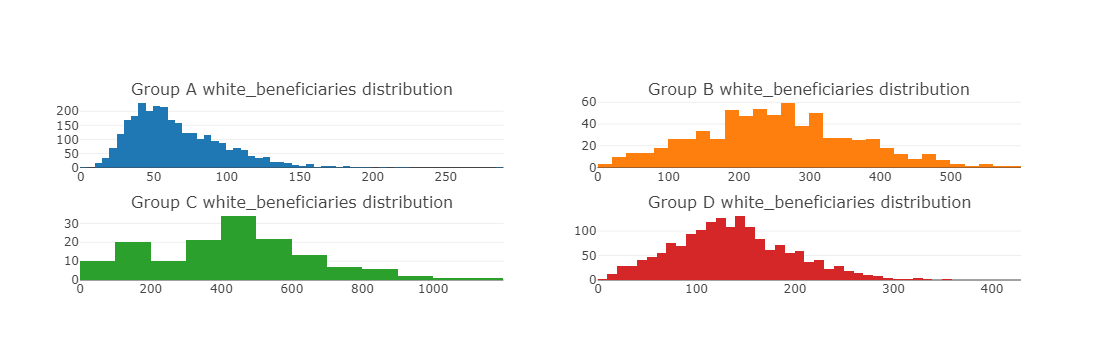

In [29]:
def generate_hist_plots(col):
    c1 = X[X['cluster'] == 0]
    trace1 = go.Histogram(x = c1[col]) 

    c2 = X[X['cluster'] == 1]
    trace2 = go.Histogram(x = c2[col]) 

    c3 = X[X['cluster'] == 2]
    trace3 = go.Histogram(x = c3[col]) 

    c4 = X[X['cluster'] == 3]
    trace4 = go.Histogram(x = c4[col]) 

    fig = tools.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=('Group A ' + col + ' distribution','Group B ' + col+ ' distribution','Group C ' + col+ ' distribution','Group D ' + col+ ' distribution'))
    fig.append_trace(trace1, 1, 1);
    fig.append_trace(trace2, 1, 2);
    fig.append_trace(trace3, 2, 1);
    fig.append_trace(trace4, 2, 2);
    fig['layout'].update(height=600, showlegend=False);
    iplot(fig, filename='simple-subplot');

col = 'white_beneficiaries'
generate_hist_plots(col)

#### Black Beneficiaries

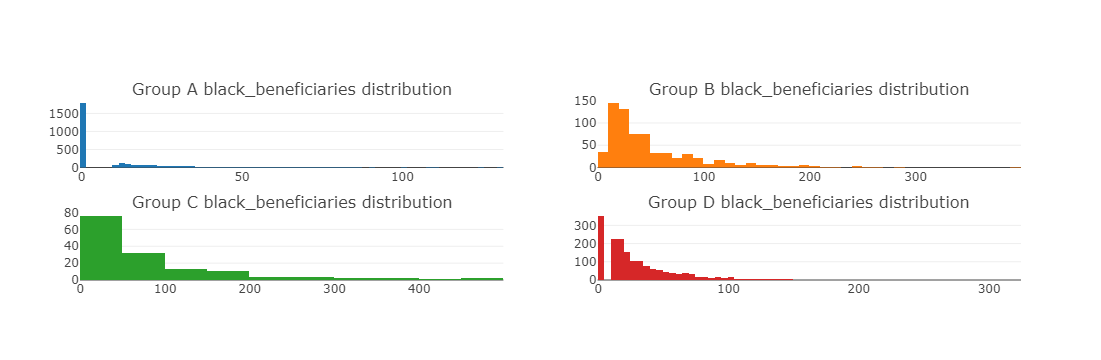

In [30]:
col = 'black_beneficiaries'
generate_hist_plots(col)

#### Distinct Beneficiaries Per Provider 

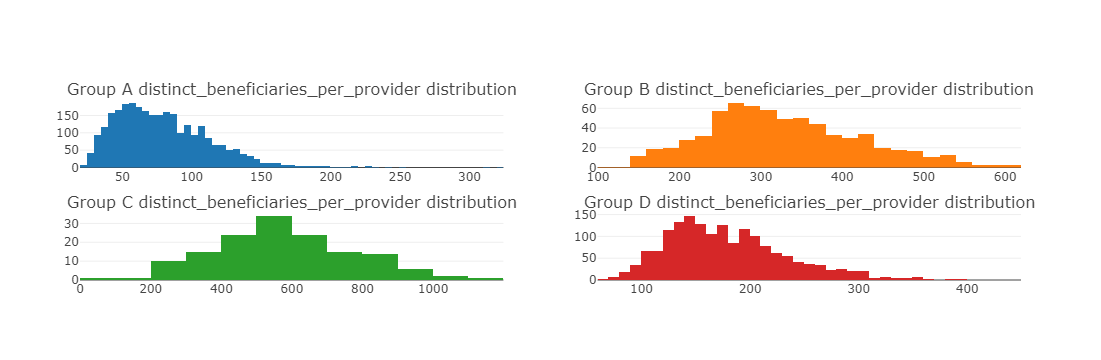

In [31]:
col = 'distinct_beneficiaries_per_provider'
generate_hist_plots(col)

#### Total Stays

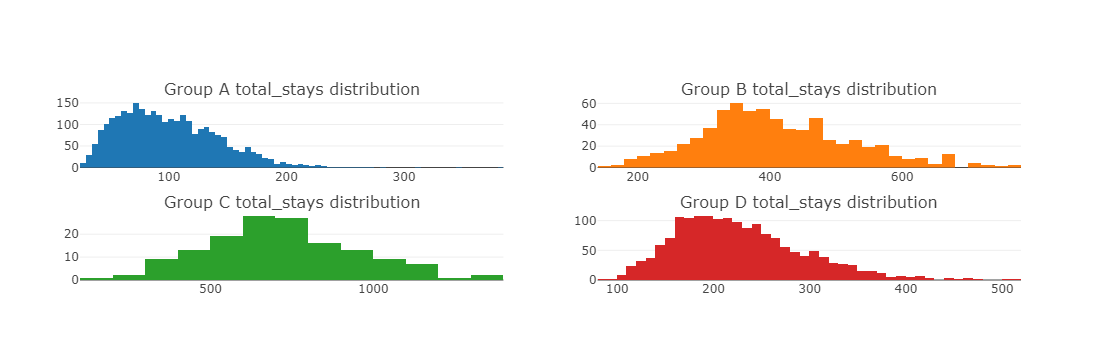

In [32]:
col = 'total_stays'
generate_hist_plots(col)

### 6.5 Inference about Different Groups

**Characteristics of Nursing Facilities in Group A**    
> - This group contains one of the best performing nursing facilities having low HCC risk scores, medicare payments etc than other groups. 
> - This group consists of nursing facilities having the HCC score is the LOWEST (mean = 2.25), which indicates that these Nursing Facilities might have performed / served better to maintain a healthy population
> - Average value of Total Skilled Nursing Facility Charge in this group is also lowest (about 1.54 Million), Medicare Payment's average value is equal to 962K with the mean value of distinct beneficiaries equal to 79. All of these values are lowest when compared to values for Nursing Facilities in Group B, C, and D. 
> - The White Beneficiary distribution of this group is scattered over to lower side with the mean of the normal curve equal to about 50. While the Black beneficiary distribution of this group contains very less data. Does this indicate that the nursing facilities in this group (almost) always serve to White Population? Maybe Yes ! 
> - Similar distribution behaviour is shown by the variables - total stays and distinct beneficiaries per providers

**Characteristics of Nursing Facilities in Group B**    
> - Group B is one of those group in which the HCC risk value is on the higher side (average = 2.40) 
> - The White population beneficiaries of this group are scattered normally pivoted at 220-239 while black population beneficiaries is much higher than group A but it still on the lower side 

**Characteristics of Nursing Facilities in Group C**    
> - Group C is the one in which mean HCC value is not that higher but mean value of Total Skilled Nursing Facility Charge (9.1 M), Medicare Payment (16.1 M), and the number of distinct beneficiaries (580) is the highest among any other groups. 
> - There is less variability in the number of black beneficiaries  and it follows a pretty standard set of values 

**Characteristics of Nursing Facilities in Group D**    
> - In Group D, the average HCC score of Nursing Facilities is the highest than any other group equal to 2.45  
